cuda


<IPython.core.display.Javascript object>


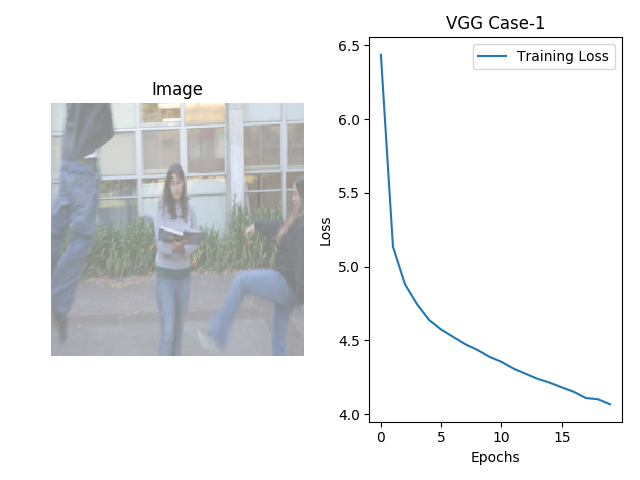

Start/Continue training from epoch 50
Finish training for 50 epochs


In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F
import torchvision as tv
from PIL import Image
import nntools as nt
import matplotlib.pyplot as plt
from dataloader import VOCDataset, myimshow
import model
import glob
from torch.autograd import Variable
class statsmanager(nt.StatsManager):
    def __init__self():
        super(statsmanager,self).__init__()

    def init(self):
        super(statsmanager,self).init()
        self.m_ap=0

    def accumulate(self,loss,x,y,d):
        #Do m_ap calculations
        super(statsmanager,self).accumulate(loss,x,y,d)
    

    def summarize(self):
        loss=super(statsmanager,self).summarize()
        return {'loss':loss}

def plot(self,fig,ax1, ax2 ,im):
    ax1.set_title('Image')
    x,y=train_set[0]
    myimshow(x,ax=ax1)
    ax2.set_title('VGG Case-1')
    ax2.plot([exp3.history[k][0]['loss']for k in range(20)],label='Training Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='best')
    plt.tight_layout()
    fig.canvas.draw()

lr=1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
vgg = model.VGGTransfer(20,16)
vgg.to(device)         
adam=torch.optim.SGD(vgg.parameters(),lr=lr,momentum=0.9, weight_decay=5e-4)
stats_manager=statsmanager()
train_set=VOCDataset('/datasets/ee285f-public/PascalVOC2012/')
valid_set=VOCDataset('/datasets/ee285f-public/PascalVOC2012/', mode="val")
test_set=VOCDataset('/datasets/home/05/705/spalania/VOCdevkit/VOC2012', mode="test")
x,y=train_set[0]

exp3=nt.Experiment(vgg,train_set,valid_set,adam,stats_manager,batch_size=16,output_dir="run4",perform_validation_during_training=True)
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
exp3.load()
exp3.run(num_epochs=50,plot=lambda exp:plot(exp,fig=fig,ax1=ax1, ax2=ax2 ,im=x))



In [2]:
exp3.history

[({'loss': 6.4351096751693095}, {'loss': 4.855014518042591}),
 ({'loss': 5.13494633546022}, {'loss': 4.680248720252254}),
 ({'loss': 4.879878237982776}, {'loss': 4.57682405231155}),
 ({'loss': 4.745208733231426}, {'loss': 4.582648467423389}),
 ({'loss': 4.638342927072014}, {'loss': 4.54875506344614}),
 ({'loss': 4.573420529371906}, {'loss': 4.520728817609983}),
 ({'loss': 4.523783413845006}, {'loss': 4.5121220933314055}),
 ({'loss': 4.474120735326342}, {'loss': 4.475109502162518}),
 ({'loss': 4.436162205977497}, {'loss': 4.491197473163545}),
 ({'loss': 4.389154789762917}, {'loss': 4.478397060406171}),
 ({'loss': 4.354914659174167}, {'loss': 4.48983043227983}),
 ({'loss': 4.3090592808971735}, {'loss': 4.469212292139404}),
 ({'loss': 4.274143720659936}, {'loss': 4.482649151781266}),
 ({'loss': 4.239743374695924}, {'loss': 4.482513103158303}),
 ({'loss': 4.213790968040599}, {'loss': 4.465939743125179}),
 ({'loss': 4.182277797538544}, {'loss': 4.4553777116852755}),
 ({'loss': 4.15172731510

In [2]:
import os
import numpy as np
import torch
from torch import nn
import torch.utils.data as td
import torchvision as tv
import xml.etree.ElementTree as ET
from PIL import Image
from matplotlib import pyplot as plt
from scipy.misc import imread,imresize
import cv2

def decoder(pred):

    pred=pred.data
    pred=pred.squeeze(0)
    contain1 = pred[:,:,4].unsqueeze(2)
    contain2 = pred[:,:,9].unsqueeze(2)
    contain = torch.cat((contain1,contain2),2)
    mask1 = contain > 0.1 
    mask2 = (contain==contain.max())
    mask = (mask1+mask2).gt(0)
    boxes=[]
    cls_indexs=[]
    probs=[]
    for i in range(7):
        for j in range(7):
            for b in range(2):
                if mask[i][j][b]==1:
                    box = pred[i,j,b*5:b*5+4]
                    xc=pred[i,j,b*5]

                    w=pred[i,j,b*5+2]
                    yc=pred[i,j,b*5+1]
                    h=pred[i,j,b*5+3]
                    x_new = torch.FloatTensor([i])*(1./7)
                    y_new=torch.FloatTensor([j])*(1./7)
                    xc=xc*(1./7)+x_new
                    yc=yc*(1./7)+y_new
                    x1=(xc-(w/2))
                    x2=(xc+(w/2))
                    y1=(yc-(h/2))
                    y2=(yc+(h/2))   
                    bbox=torch.FloatTensor(box.size())
                    bbox[0]=x1
                    bbox[1]=y1
                    bbox[2]=x2
                    bbox[3]=y2
                    contain_prob=torch.FloatTensor([pred[i,j,b*5+4]])
                    max_prob,cls_index = torch.max(pred[i,j,10:],0)
                    if float((contain_prob*max_prob)[0]) > 0.1:
                        boxes.append(bbox.view(1,4))
                        cls_indexs.append(cls_index)
                        probs.append(contain_prob*max_prob)
    print(cls_indexs)
    if len(boxes)==0 or len(cls_indexs)==0:
        boxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        cls_indexs = torch.zeros(1)
    else:
        boxes = torch.cat(boxes,0) #(n,4)
        probs = torch.cat(probs,0) #(n,)
        cls_indexs = torch.stack(cls_indexs,0) #(n,)
    return boxes,probs,cls_indexs

In [3]:
voc_dict1 = {0:'person', 1:'bird', 2:'cat', 3:'cow', 4:'dog',5:'horse', 6:'sheep', 7:'aeroplane', 8:'bicycle',9:'boat', 10:'bus', 11:'car', 12:'motorbike', 13:'train', 14:'bottle', 15:'chair', 16:'diningtable', 17:'pottedplant', 18:'sofa', 19:'tvmonitor'}
path='/datasets/home/05/705/spalania/mAP/input/detection-results/'
img_path='/datasets/home/88/288/mkulkarn/VOCdevkit/VOC2012/JPEGImages/'
for i in range(len(test_set)):
    x,y,z=test_set[i]
    print(z,i)
    x=x.view(1,3,224,224)
    x=x.to('cuda')
    op=vgg(x)
    op=op.view(7,7,30)
    a,b,c=decoder(op)
    img_path1=os.path.join(img_path,z+'.jpg')
    img = imread(img_path1)
    h,w,_=img.shape
    if a.shape[1]==1:
        a=a.view(1,4)
        b=b.view(1)
        c=c.view(1)
    a=a.detach().numpy()
    b=b.detach().numpy()
    c=c.to('cpu')
    c=c.detach().numpy()
    file_path=os.path.join(path,z+'.txt')
    f=open(file_path,'w')
    for j in range(len(a)):
        
        f.write(voc_dict1[c[j].item()]+' '+str(b[j].item())+' '+str(int(a[j][0].item()*w))+' '+str(int(a[j][1].item()*h))+' '+str(int(a[j][2].item()*w))+' '+str(int(a[j][3].item()*h)))
        f.write('\n')
    f.close()
    

2008_006602 0
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004959 1
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000785 2
[tensor(0, device='cuda:0')]
2011_000435 3


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000847 4
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003919 5
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007042 6
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000392 7
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003952 8
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005300 9
[tensor(0, device='cuda:0')]
2011_003520 10
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000196 82
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006796 83
[tensor(0, device='cuda:0')]
2008_001834 84
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001446 85
[]
2010_002538 86
[tensor(0, device='cuda:0')]
2008_004318 87
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000631 88
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device=

2011_006747 160
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003052 161
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005652 162
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004877 163
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002225 164
[tensor(0, device='cuda:0')]
2007_008468 165
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007909 166
[tensor(0, device='cuda:0')]
2007_001884 167
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
2010_005245 168
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004012 169
[]
2009_002632 170
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002612 171
[tensor(0, device='cuda:0'), tensor(0, 

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001155 240
[tensor(2, device='cuda:0')]
2010_006970 241
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006502 242
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007748 243
[]
2012_003261 244
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003241 245
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005813 246
[tensor(0, device='cuda:0')]
2011_005461 247
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004191 248
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000498 249
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003994 250
[tensor(7, device='cuda:0')]
2009_002401 251
[tensor(0,

2011_002244 322
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004464 323
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003789 324
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005189 325
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001480 326
[tensor(0, device='cuda:0')]
2010_004479 327
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002259 328
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001327 329
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007975 330
[tensor(

2010_005410 403
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_003251 404
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001172 405
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001152 406
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006505 407
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000325 408
[tensor(0, device='cuda:0')]
2010_006977 409
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, dev

2010_003014 481
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005634 482
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
2008_005193 483
[]
2011_002996 484
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003871 485
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003403 486
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002654 487
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004074 488
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002815 558
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004247 559
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003630 560
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008220 561
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003197 562
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001572 563
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007352 564
[tensor(0, device='cuda:0')]
2011_000725 565
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_008994 566
[tenso

2012_001417 638
[]
2012_001865 639
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004369 640
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000660 641
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006040 642
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001390 643
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
2008_005699 644
[]
2010_006091 645
[]
2009_001894 646
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002598 647
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, de

2011_003642 729
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005062 730
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008252 731
[tensor(0, device='cuda:0')]
2008_001919 732
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004235 733
[tensor(0, device='cuda:0')]
2010_003980 734
[tensor(0, device='cuda:0')]
2010_003255 735
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006979 736
[tensor(0, device='cuda:0')]
2011_002002 737
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004622 738
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006912 739
[

2008_003707 805
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004370 806
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002922 807
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002902 808
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002570 809
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006795 810
[]
2010_006032 811
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001837 812
[]
2012_001465 813
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
201

2011_002369 881
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001237 882
[tensor(0, device='cuda:0')]
2009_001217 883
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_003134 884
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006660 885
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002485 886
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004285 887
[tensor(0, device='cuda:0')]
2012_002322 888
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004522 889
[]
2011_004950 890
[tensor(0, device

2012_001933 965
[tensor(0, device='cuda:0')]
2012_001541 966
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004598 967
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006973 968
[]
2009_000321 969
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006501 970
[tensor(0, device='cuda:0')]
2012_000301 971
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000486 972
[tensor(7, device='cuda:0')]
2008_008376 973
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006038 974
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003766 975
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000638 976
[tensor(0, device='cuda:0'), tensor(0, 

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005365 1048
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002305 1049
[tensor(0, device='cuda:0')]
2011_004957 1050
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004525 1051
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002325 1052
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003152 1053
[]
2011_004282 1054
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002482 1055
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, dev

2011_006506 1123
[]
2011_006974 1124
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001171 1125
[tensor(0, device='cuda:0')]
2008_000096 1126
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000731 1127
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006111 1128
[]
2009_001566 1129
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004218 1130
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002418 1131
[]
2012_001546 1132
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001934 1133
[tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, d

2009_000169 1197
[tensor(0, device='cuda:0')]
2010_002995 1198
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005190 1199
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004057 1200
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007109 1201
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001709 1202
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002657 1203
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005220 1204
[tensor(7, device='cuda:0')]
2010_003400 1205
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
2008_007797 1206
[]
2008_007030 1207
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003519 1208
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005319 1209
[tensor(

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003776 1288
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002521 1289
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004301 1290
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003361 1291
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005541 1292
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004716 1293
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002136 1294
[tensor(0, device='cuda:0')]
2012_

2011_004873 1360
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003076 1361
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006728 1362
[tensor(0, device='cuda:0')]
2012_000692 1363
[tensor(0, device='cuda:0')]
2011_006092 1364
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000135 1365
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006735 1366
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005989 1367
[]
2010_006485 1368
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001755 1369
[]
2011_007175 1370
[tensor(0, device='cuda:0'), tensor(0, devi

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000024 1440
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006594 1441
[]
2008_005898 1442
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000413 1443
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006233 1444
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000861 1445
[]
2012_001664 1446
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007064 1447
[tensor(0, device='cuda:0')]
2009_001644 1448
[tensor(0, device='cuda:0'), tensor(0, device='cud

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000141 1512
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006761 1513
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002248 1514
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002268 1515
[tensor(0, device='cuda:0')]
2011_004448 1516
[tensor(0, device='cuda:0')]
2012_001888 1517
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003054 1518
[tensor(0, device='cuda:0')]
2011_002203 1519
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008053 1520
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003443 1521
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_00

2011_003670 1591
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001940 1592
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007312 1593
[]
2011_000765 1594
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006920 1595
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000372 1596
[tensor(0, device='cuda:0')]
2008_003908 1597
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006224 1598
[tensor(0, device='cuda:0')]
2010_000876 1599
[tensor(0, device='cuda:0

2010_003028 1665
[tensor(0, device='cuda:0')]
2008_005608 1666
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001321 1667
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001301 1668
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_003022 1669
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001486 1670
[tensor(0, device='cuda:0')]
2011_006361 1671
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000913 1672
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000561 1673
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007191 1732
[]
2012_001791 1733
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001016 1734
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001036 1735
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004748 1736
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002168 1737
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006461 1738
[]
2010_006813 1739
[tensor(0, device='cuda:0')]
2008_001401 1740
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003728 1741
[ten

2011_006599 1802
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000399 1803
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008170 1804
[tensor(0, device='cuda:0')]
2011_003560 1805
[tensor(0, device='cuda:0')]
2011_003912 1806
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002737 1807
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001649 1808
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004287 1809
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000009 1810
[tensor(0, device='cuda:0')]
2010_006629 1811
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001869 1875
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002937 1876
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002545 1877
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003732 1878
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004890 1879
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003095 1880
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:

[tensor(0, device='cuda:0')]
2011_006534 1949
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000334 1950
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_007769 1951
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004600 1952
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002000 1953
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000309 1954
[tensor(0, device='cuda:0')]
2010_005825 1955
[]
2008_003277 1956
[tensor(0, device='cuda:0'), tensor(0, dev

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007935 2023
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001367 2024
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004439 2025
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003459 2026
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005279 2027
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000955 2028
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006307 2029
[tensor(0, device='cuda:0')]
2010_000527 2030
[]
2011_001770 2031
[tensor(0, device='cuda:0'), tensor(0, device='cuda:

2007_009562 2103
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007596 2104
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007231 2105
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001863 2106
[]
2010_001411 2107
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005118 2108
[]
2009_003738 2109
[tensor(0, device='cuda:0')]
2012_003718 2110
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000646 2111
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005044 2112
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002413 2113
[tensor(0, devi

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002494 2182
[tensor(0, device='cuda:0')]
2010_001998 2183
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003144 2184
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005744 2185
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003164 2186
[tensor(0, device='cuda:0')]
2012_004289 2187
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006180 2188
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001270 2189
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006627 2190
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

2011_002972 2261
[tensor(0, device='cuda:0')]
2008_006062 2262
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_000648 2263
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002939 2264
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005979 2265
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001002 2266
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007185 2267
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006468 2268
[tensor(0, device='cuda:0'), tensor(0, device

2007_007470 2330
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004133 2331
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004113 2332
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000868 2333
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005891 2334
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001650 2335
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007070 2336
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005359 2337
[tensor(0, device='cuda:0')]
2012_003559 2338
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000875 2339
[tensor(0, device='cuda:0')]
2012_002

2009_003736 2418
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005116 2419
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000648 2420
[tensor(0, device='cuda:0')]
2012_003716 2421
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004341 2422
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002913 2423
[tensor(0, device='cuda:0')]
2008_002561 2424
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005501 2425
[tensor(0, device

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003174 2497
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_007477 2498
[tensor(0, device='cuda:0')]
2009_002499 2499
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006190 2500
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001240 2501
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006637 2502
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_009724 2503
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002729 2504
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004109 2505
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

2012_002942 2569
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002962 2570
[tensor(0, device='cuda:0')]
2011_004330 2571
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002510 2572
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002297 2573
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004497 2574
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000652 2575
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001857 2576
[tensor(0, device='cuda:0'), tensor(0, device

[tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004199 2650
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000317 2651
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006945 2652
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006537 2653
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005449 2654
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003269 2655
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004380 2722
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000689 2723
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004848 2724
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000133 2725
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000694 2726
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001773 2727
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003808 2728
[tenso

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000598 2801
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005913 2802
[tensor(0, device='cuda:0')]
2011_005561 2803
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003361 2804
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007648 2805
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002116 2806
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002286 2807
[tensor(0, device='cuda:0'), tenso

2012_003865 2865
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003417 2866
[tensor(0, device='cuda:0')]
2008_001775 2867
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006302 2868
[]
2009_000522 2869
[]
2012_000502 2870
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000970 2871
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000285 2872
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001342 2873
[tensor(0, device='cuda:0')]
2010_006715 2874
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012

2012_001448 2955
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001468 2956
[tensor(0, device='cuda:0')]
2012_004316 2957
[]
2008_008746 2958
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006408 2959
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000208 2960
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003356 2961
[tensor(0, device='cuda:0')]
2011_003883 2962
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devi

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004179 3029
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004159 3030
[]
2009_001627 3031
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007007 3032
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006250 3033
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000470 3034
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001230 3035
[]
2009_000067 3036
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006647 3037
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_002344 3038
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), ten

2011_002788 3105
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004188 3106
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005841 3107
[]
2008_003213 3108
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005433 3109
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002064 3110
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004664 3111
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002044 3112
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005394 3113
[]
2011_005024 3114
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_001955 3115
[tensor(0, device='cuda:0'), tensor(0, devi

2009_001319 3180
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001339 3181
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005610 3182
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000579 3183
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003427 3184
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003855 3185
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006379 3186
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000559 3187
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008037 3188
[tensor(0, device='cuda:0')

2010_006140 3258
[tensor(0, device='cuda:0')]
2012_001517 3259
[tensor(7, device='cuda:0')]
2012_001965 3260
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001945 3261
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001537 3262
[tensor(0, device='cuda:0')]
2012_004249 3263
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005055 3264
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003675 3265
[]
2012_002870 3266
[tensor(0, device='cuda:0')]
2012_002402 3267
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002422 3268
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004202 3269
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

2012_003707 3335
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004350 3336
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003080 3337
[tensor(0, device='cuda:0')]
2008_007589 3338
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003330 3339
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001019 3340
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002147 3341
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004747 3342
[tensor(0, device='cuda:0')]
2008_003497 3343
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[]
2011_002343 3412
[tensor(0, device='cuda:0')]
2010_003114 3413
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005734 3414
[tensor(0, device='cuda:0')]
2011_006988 3415
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002754 3416
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004174 3417
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008113 3418
[tensor(0, device='cuda:0')]
2011_003971 3419
[tensor(0, device='cuda:0')]
2011_003503 3420
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002098 3421
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007061 3422
[tensor(0, device='cuda:0')]
2011_005348 3423
[tensor(0, device='cuda:0')]
2011_000416 3424
[tensor(

2011_004881 3484
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004354 3485
[tensor(0, device='cuda:0')]
2012_002554 3486
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002926 3487
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001878 3488
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003099 3489
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002569 3490
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001865 3491
[tensor(0, device='cuda:0')]
2011_006060 3492
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

2010_006760 3560
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000140 3561
[tensor(0, device='cuda:0')]
2012_001337 3562
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004449 3563
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002269 3564
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003799 3565
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001490 3566
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003507 3567
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001178 3633
[tensor(0, device='cuda:0')]
2008_005823 3634
[tensor(7, device='cuda:0')]
2008_005451 3635
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001061 3636
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007641 3637
[tensor(0, device='cuda:0'), tensor(10, device='cuda:0')]
2012_003368 3638
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003348 3639
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005568 3640
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_004092 3641
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004328 3642
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor

2010_004570 3716
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002350 3717
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005497 3718
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005330 3719
[tensor(0, device='cuda:0')]
2008_003962 3720
[tensor(0, device='cuda:0')]
2008_003510 3721
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_000464 3722
[tensor(7, device='cuda:0')]
2011_004167 3723
[tensor(0, device='cuda:0')]
2012_002767 3724
[tensor(0, device='cuda:0')]
2010_006582 3725
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000405 3726
[tensor(7, device='cuda:0')]
2010_006225 3727
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_003571 3728
[]
2011_007072 3729
[tensor(0, device='

2008_000373 3799
[tensor(10, device='cuda:0')]
2010_006921 3800
[tensor(0, device='cuda:0')]
2010_006553 3801
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001683 3802
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002031 3803
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004611 3804
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002011 3805
[tensor(0, device='cuda:0')]
2010_000318 3806
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006538 3807
[tensor(0, device='cuda:0')]
2008_003266 3808
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002854 3809
[tensor(0, device='cuda:0'), tensor(0, device=

2011_003452 3876
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002605 3877
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005219 3878
[tensor(0, device='cuda:0')]
2012_003419 3879
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000547 3880
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000935 3881
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007130 3882
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001710 3883
[tensor(0, device='cuda:0')]
2008_007697 3884

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001562 3949
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006135 3950
[tensor(0, device='cuda:0')]
2008_000715 3951
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004277 3952
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002457 3953
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001529 3954
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002477 3955
[tensor(0, device='cuda:0')]
2012_002805 3956
[tensor(0, device='cuda:0')]
2010_001699 3957
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

2008_000985 4025
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001410 4026
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001862 4027
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000667 4028
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003739 4029
[tensor(0, device='cuda:0')]
2009_005119 4030
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006067 4031
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000647 4032
[tensor(11, device='cuda:0')]
2010_004325 4033
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006981 4099
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002757 4100
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004177 4101
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006254 4102
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001609 4103
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007009 4104
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004157 4105
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tens

2009_001359 4172
[]
2008_005650 4173
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000519 4174
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006339 4175
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005247 4176
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003815 4177
[tensor(0, device='cuda:0')]
2011_003467 4178
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000539 4179
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001082 4180
[tensor(0, device='cuda:

2010_006058 4243
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000678 4244
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004371 4245
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002551 4246
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005681 4247
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001388 4248
[]
2010_006561 4249
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006913 4250
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004648 4251
[]
2012_001136 4252
[tens

2009_000833 4324
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006261 4325
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002755 4326
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004155 4327
[tensor(0, device='cuda:0')]
2008_003522 4328
[]
2008_002362 4329
[tensor(0, device='cuda:0')]
2010_004930 4330
[]
2010_004542 4331
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005715 4332
[tensor(0, device='cuda:0')]
2012_003115 4333
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
201

2010_005922 4410
[tensor(0, device='cuda:0')]
2008_003370 4411
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002127 4412
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004707 4413
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002107 4414
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006394 4415
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000594 4416
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006433 4417
[tensor(0, device='cuda:0'), tensor(0, device

2012_001988 4482
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004284 4483
[tensor(0, device='cuda:0')]
2008_004134 4484
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002714 4485
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003543 4486
[]
2011_003931 4487
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001601 4488
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007021 4489
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003508 4490
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000824 4491
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor

2010_003818 4559
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001881 4560
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006084 4561
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000684 4562
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000103 4563
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006723 4564
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000123 4565
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_0

[]
2011_000327 4640
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007750 4641
[tensor(0, device='cuda:0')]
2011_001567 4642
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001915 4643
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002439 4644
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_005064 4645
[tensor(0, device='cuda:0')]
2011_004239 4646
[tensor(0, device='cuda:0')]
2009_002419 4647
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000097 4648
[tensor(0, device='cuda:0')]
2010_003625 4649
[]
2011_002472 4650
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, dev

2009_003879 4720
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001085 4721
[]
2011_002641 4722
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004041 4723
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000568 4724
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006348 4725
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003864 4726
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005236 4727
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001098 47

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002024 4792
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004594 4793
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003664 4794
[tensor(0, device='cuda:0')]
2009_003644 4795
[]
2011_005064 4796
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000080 4797
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000727 4798
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006107 4799
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003659 4800
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001550 4801
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tenso

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008549 4874
[tensor(0, device='cuda:0')]
2009_000027 4875
[tensor(0, device='cuda:0')]
2008_004289 4876
[tensor(0, device='cuda:0')]
2008_005182 4877
[tensor(0, device='cuda:0')]
2011_002987 4878
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005625 4879
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002252 4880
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006899 4881
[tensor(0, device='cuda:0')]
2011_003412 4882
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005232 4883
[]
2011_003860 4884
[tensor(0, devic

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001163 4950
[tensor(0, device='cuda:0')]
2012_001143 4951
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005818 4952
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006966 4953
[]
2010_006514 4954
[]
2008_000493 4955
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001574 4956
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000703 4957
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_002400 4958
[tensor(0, device='cud

2012_000414 5032
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000866 5033
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001663 5034
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004687 5035
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002087 5036
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005377 5037
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003925 5038
[tensor(0, device='cuda:0'), tenso

2010_003418 5108
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001711 5109
[tensor(0, device='cuda:0')]
2009_001731 5110
[tensor(0, device='cuda:0')]
2011_007111 5111
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006893 5112
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006899 5113
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001096 5114
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006397 5115
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001067 5116
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

2008_008231 5184
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001967 5185
[tensor(0, device='cuda:0')]
2012_002839 5186
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007085 5187
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005879 5188
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004190 5189
[tensor(0, device='cuda:0')]
2009_000499 5190
[]
2011_003995 5191
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002017 5192
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001169 5193
[]
2011

2009_004409 5261
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001377 5262
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001357 5263
[tensor(0, device='cuda:0')]
2012_003043 5264
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003063 5265
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005643 5266
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_001340 5267
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004866 5268
[tensor(0, device='cuda:0'), tensor(0, device

2011_006441 5326
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006833 5327
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000241 5328
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001791 5329
[tensor(0, device='cuda:0')]
2012_000994 5330
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004703 5331
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002123 5332
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005926 5333
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006219 5404
[]
2008_005367 5405
[tensor(7, device='cuda:0')]
2010_003547 5406
[tensor(0, device='cuda:0')]
2012_004110 5407
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000789 5408
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004280 5409
[]
2011_003150 5410
[]
2008_004955 5411
[tensor(0, device='cuda:0')]
2010_002307 5412
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000045 5413
[]
2010_001212 5414
[tensor(0, device='cuda:0')]
2008_007840 5415
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007432 5416
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006272 5417
[]
2011_001605 5418
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000919 5419
[tensor(0, device='cuda:0'), t

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008773 5490
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003363 5491
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001901 5492
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000724 5493
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006104 5494
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000704 5495
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001144 5496
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001164 5497
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006513 5498
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

[]
2010_004297 5569
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003922 5570
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001679 5571
[]
2012_002727 5572
[tensor(0, device='cuda:0')]
2011_004127 5573
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000389 5574
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002080 5575
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004680 5576
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006265 5577
[tensor(0, device='cuda:0')]
2008_000837 5578
[tensor(0, device='cuda:0'), ten

2012_000838 5650
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004163 5651
[tensor(0, device='cuda:0')]
2010_003103 5652
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004906 5653
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005084 5654
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002881 5655
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003168 5656
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005748 5657
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_009082 5658
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001994 5659
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0

2011_004496 5732
[tensor(0, device='cuda:0')]
2012_002531 5733
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002943 5734
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004331 5735
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003746 5736
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005166 5737
[tensor(0, device='cuda:0')]
2009_000182 5738
[tensor(0, device='cuda:0')]
2012_000605 5739
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000625 5740
[tensor(0, device='cuda:0')]
2011_006005 5741
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003899 5742
[tensor(0, device='cuda:0')]
2008_000595 5743
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), 

2008_007819 5807
[tensor(0, device='cuda:0')]
2010_004515 5808
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002335 5809
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004967 5810
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003907 5811
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003575 5812
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000879 5813
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_0

2009_004822 5884
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000695 5885
[]
2010_000132 5886
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006712 5887
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004849 5888
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000282 5889
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003829 5890
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003809 5891
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000957 5892
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006943 5963
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000311 5964
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002388 5965
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000081 5966
[]
2011_006681 5967
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001551 5968
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003678 5969
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000726 5970
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000706 5971
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008268 5972
[tenso

[]
2009_000128 6041
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006708 6042
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000108 6043
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002201 6044
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005261 6045
[]
2012_001748 6046
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002616 6047
[tensor(0, device='cuda:0'), t

2011_005389 6122
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003589 6123
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004612 6124
[tensor(0, device='cuda:0')]
2010_002032 6125
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006949 6126
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008675 6127
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001909 6128
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_

2011_004786 6192
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005276 6193
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002621 6194
[tensor(0, device='cuda:0')]
2011_004021 6195
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000698 6196
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004391 6197
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005661 6198
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003061 6199
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device

2010_002979 6261
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001475 6262
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006002 6263
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000602 6264
[tensor(0, device='cuda:0')]
2011_005117 6265
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003717 6266
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000649 6267
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007599 6268
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003090 6269
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001009 6270
[tensor(0

2011_003913 6338
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006598 6339
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000398 6340
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002321 6341
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004501 6342
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000008 6343
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006628 6344
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003176 6345
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004286 6346
[tensor(0, device='cuda:0')

[]
2012_001823 6411
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000211 6412
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006411 6413
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006863 6414
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001066 6415
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002118 6416
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003304 6417
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005976 6418
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, de

2010_005824 6491
[]
2008_003276 6492
[tensor(0, device='cuda:0')]
2010_005456 6493
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004601 6494
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002001 6495
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003641 6496
[]
2011_005041 6497
[tensor(0, device='cuda:0')]
2008_002436 6498
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004216 6499
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001548 6500
[tensor(0, device='cuda:0')]
2010_001599 6501
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003690 6502
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005090 6503
[tensor

2008_007546 6563
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001366 6564
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002218 6565
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002188 6566
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004788 6567
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001771 6568
[tensor(0, device='cuda:0')]
2008_003458 6569
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000954 6570
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000526 6571
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004795 6572
[tensor(0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002467 6645
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003580 6646
[]
2011_005380 6647
[tensor(11, device='cuda:0')]
2010_001689 6648
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003227 6649
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000379 6650
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005855 6651
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005427 6652
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, de

2010_006653 6721
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000444 6722
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000836 6723
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003968 6724
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006244 6725
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000816 6726
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000464 6727
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001194 6728
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006991 6729
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008345 6798
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000712 6799
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002849 6800
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002869 6801
[tensor(0, device='cuda:0')]
2011_001937 6802
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000305 6803
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005829 6804
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001152 6805
[]
2008_008600 6806
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001139 6807
[tensor(0, device='cuda:0'), tenso

[]
2012_000101 6882
[]
2009_000121 6883
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006701 6884
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004798 6885
[tensor(0, device='cuda:0')]
2008_000291 6886
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007141 6887
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001741 6888
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006316 6889
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000944 6890
[]
2008_000536 6891
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), 

2011_004085 6961
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002685 6962
[tensor(0, device='cuda:0')]
2010_004694 6963
[]
2011_000848 6964
[tensor(0, device='cuda:0')]
2012_003916 6965
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003564 6966
[tensor(0, device='cuda:0')]
2009_003544 6967
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005364 6968
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003936 6969
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_001667 6970
[]
2010_004133 6971
[tensor(0, device='cuda:0'), tensor(0, devi

2008_006968 7039
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002794 7040
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004194 7041
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001170 7042
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003259 7043
[tensor(0, device='cuda:0')]
2012_000307 7044
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006507 7045
[tensor(0, device='cuda:0')]
2008_008649 7046
[]
2009_000327 7047
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006975 7048
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004189 7049
[tensor(0, device='cuda:0'), tensor(0, device

2011_003477 7120
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005257 7121
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003805 7122
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000529 7123
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004000 7124
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002620 7125
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0

2008_005801 7201
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003253 7202
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005473 7203
[]
2007_007892 7204
[tensor(0, device='cuda:0')]
2010_002413 7205
[tensor(0, device='cuda:0')]
2008_008254 7206
[tensor(0, device='cuda:0')]
2009_005064 7207
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003644 7208
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004589 7209
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002389 7210
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000080 7211
[tensor(0, device='cuda:0')]
2011_001570 7212
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

2011_005291 7269
[tensor(0, device='cuda:0')]
2012_003491 7270
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005536 7271
[tensor(0, device='cuda:0')]
2011_005944 7272
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003316 7273
[tensor(0, device='cuda:0'), tensor(10, device='cuda:0')]
2012_003336 7274
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000268 7275
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005240 7276
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003460 727

2010_003522 7344
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004175 7345
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002775 7346
[]
2011_003692 7347
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008525 7348
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_002368 7349
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004930 7350
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000787 7351
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_004951 7352
[tensor(0, device='cuda:0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000224 7428
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006424 7429
[]
2011_006856 7430
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000583 7431
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006383 7432
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004766 7433
[]
2008_002146 7434
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007618 7435
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003331 7436
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cu

2011_005363 7501
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003543 7502
[tensor(7, device='cuda:0')]
2012_003563 7503
[tensor(0, device='cuda:0')]
2012_003911 7504
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002714 7505
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000456 7506
[]
2009_000824 7507
[tensor(7, device='cuda:0')]
2009_005308 7508
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003528 7509
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000804 7510
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000476 7511
[tensor(0, device='cuda:0')]
2008_001601 7512
[tensor(0, device='cuda:0')

2008_001177 7577
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006972 7578
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000320 7579
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006500 7580
[tensor(0, device='cuda:0')]
2012_000300 7581
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003592 7582
[tensor(0, device='cuda:0'), tensor(10, device='cuda:0')]
2008_002062 7583
[tensor(0, device='cuda:0')]
2010_004642 7584
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005415 7585
[tensor(0, device='cuda:0')]
2011_005867 7586
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(

2008_000578 7655
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003406 7656
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003874 7657
[tensor(0, device='cuda:0')]
2009_004071 7658
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002651 7659
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004051 7660
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003011 7661
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004814 7662
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001338 7663

2008_002471 7734
[tensor(0, device='cuda:0')]
2008_002803 7735
[tensor(0, device='cuda:0')]
2009_003181 7736
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007488 7737
[tensor(0, device='cuda:0')]
2008_003231 7738
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004646 7739
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002066 7740
[tensor(0, device='cuda:0')]
2012_002046 7741
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003596 7742
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006900 7743
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006572 7744
[tensor(0, device='

[tensor(0, device='cuda:0')]
2011_005249 7810
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003469 7811
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006087 7812
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004409 7813
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002229 7814
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002209 7815
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001357 7816
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006720 7817
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004866 7818
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004414 7819
[]
2011_

2012_002829 7894
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002809 7895
[]
2008_007095 7896
[]
2011_005869 7897
[tensor(0, device='cuda:0')]
2011_000345 7898
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001112 7899
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003985 7900
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003250 7901
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006119 7902
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002410 7903
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
201

2012_003343 7960
[tensor(0, device='cuda:0')]
2011_005931 7961
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003363 7962
[]
2011_005543 7963
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004714 7964
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004062 7965
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003847 7966
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003435 7967
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devi

2008_005716 8025
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006668 8026
[]
2011_004958 8027
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000023 8028
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000393 8029
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007043 8030
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003918 8031
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000434 8032
[tensor(0, device='cuda:0')]
2009_003938 8033
[tensor(0, device='cuda:0

2012_003082 8102
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005682 8103
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000666 8104
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001863 8105
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001411 8106
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001431 8107
[tensor(0, device='cuda:0'), tensor(4, device='cuda:0')]
2011_007211 8108
[tensor(0, device='cuda:0')]
2011_006823 8109
[tensor(0, device='cuda:0')]
2011_006451 8110
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006351 8174
[tensor(0, device='cuda:0')]
2012_000146 8175
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006746 8176
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004924 8177
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002376 8178
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004556 8179
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002356 8180
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001208 8181
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002883 81

2007_003191 8246
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001292 8247
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000742 8248
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006162 8249
[]
2009_001967 8250
[tensor(0, device='cuda:0')]
2012_001535 8251
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001947 8252
[tensor(0, device='cuda:0')]
2011_002819 8253
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000375 8254
[tensor(0, device='cuda:0

2008_007167 8328
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002639 8329
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004024 8330
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002624 8331
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004004 8332
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003801 8333
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005253 8334
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003473 8335
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004413 8336
[tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002931 8408
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002543 8409
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000186 8410
[]
2011_006786 8411
[tensor(0, device='cuda:0')]
2012_000621 8412
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006021 8413
[]
2008_001456 8414
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004308 8415
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006391 8416
[tensor(0, device='cud

2010_001104 8484
[]
2008_007724 8485
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004998 8486
[]
2010_000744 8487
[]
2008_006164 8488
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001961 8489
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004949 8490
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003909 8491
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003929 8492
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_001678 8493
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000382 8494
[]
2008_001619 8495
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004147 8496
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), te

2008_004374 8563
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003314 8564
[]
2008_005534 8565
[tensor(0, device='cuda:0')]
2010_006838 8566
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006832 8567
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004763 8568
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002143 8569
[tensor(7, device='cuda:0')]
2008_006421 8570
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004708 8571
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002128 8572
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002108 8573
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001056 8574
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0')]
2011_002808 8639
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001956 8640
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001524 8641
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001283 8642
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000364 8643
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006916 8644
[]
2009_000344 8645
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006564 8646
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001113 8

2009_003019 8717
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005639 8718
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003039 8719
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001497 8720
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008462 8721
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002582 8722
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004012 8723
[tensor(0, device='cuda:0')]
2012_004032 8724
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005245 8725
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003465 8726
[tensor(0, device='cuda:0')]
2008_005294 8727
[tensor(0, device='cuda:0'), tensor(0, device=

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006563 8801
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000343 8802
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006911 8803
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000363 8804
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001114 8805
[]
2012_001284 8806
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004988 8807
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
20

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003856 8876
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005224 8877
[tensor(0, device='cuda:0')]
2011_004464 8878
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004816 8879
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002264 8880
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003013 8881
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005189 8882
[tensor(7, device='cuda:0')]
2008_004479 8883
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006750 8884
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

2011_006835 8951
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006447 8952
[tensor(0, device='cuda:0')]
2008_001030 8953
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000992 8954
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001797 8955
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006050 8956
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000670 8957
[tensor(0, device='cuda:0')]
2009_001427 8958
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007207 8959
[tensor(0, device='cuda:0')]
2012_001875 8960
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0

2008_008546 9029
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000028 9030
[tensor(11, device='cuda:0')]
2011_006608 9031
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000398 9032
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007048 9033
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004116 9034
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001648 9035
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003541 9036
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005361 9037
[tensor(0, device='cuda:0'

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005520 9105
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003300 9106
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005952 9107
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001399 9108
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_000663 9109
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004360 9110
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002932 9111
[tensor(15, device='cuda:0')]
2012_002560 9112
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devi

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000849 9177
[tensor(7, device='cuda:0')]
2011_003937 9178
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003545 9179
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000869 9180
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004695 9181
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004525 9182
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_008927 9183
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007446 9184
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000426 9185
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001671 9186
[tensor(0, device='cuda:0'), tensor

2008_001799 9258
[tensor(0, device='cuda:0')]
2008_007675 9259
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000202 9260
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003889 9261
[tensor(0, device='cuda:0')]
2008_006792 9262
[tensor(0, device='cuda:0')]
2011_004625 9263
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002025 9264
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005472 9265
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003252 9266
[tensor(0, device='cuda:0')]
2010_005800 9267
[tensor(0, device='cuda:0')]
2011_004182 9268
[tensor(0, device='

2008_002705 9336
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006211 9337
[tensor(0, device='cuda:0')]
2012_004118 9338
[tensor(0, device='cuda:0')]
2011_007046 9339
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001646 9340
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004138 9341
[tensor(0, device='cuda:0')]
2009_000781 9342
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004288 9343
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003158 9344
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000006 9345
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0

2008_005680 9418
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004370 9419
[tensor(0, device='cuda:0')]
2011_002550 9420
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005127 9421
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001445 9422
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001837 9423
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002969 9424
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006032 9425
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001052 9426
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000859 9497
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005375 9498
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003555 9499
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
2010_005762 9500
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004535 9501
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004947 9502
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002335 9503
[tenso

2012_003746 9576
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000618 9577
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005146 9578
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002296 9579
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002126 9580
[tensor(10, device='cuda:0')]
2011_004706 9581
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0')]
2011_001058 9582
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002106 9583
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005551 9584
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0

2011_005309 9654
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006660 9655
[]
2011_004549 9656
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002349 9657
[]
2011_001217 9658
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004285 9659
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001989 9660
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004692 9661
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003542 9662
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003930 9663
[tensor(0, device='cuda:0'), tens

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007922 9738
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003079 9739
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_004856 9740
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005679 9741
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003059 9742
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003795 9743
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004837 9744
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tenso

2011_005340 9814
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003560 9815
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002487 9816
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004500 9817
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004972 9818
[tensor(0, device='cuda:0')]
2009_002320 9819
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002300 9820
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006629 9821
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000009 9822
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000207 9884
[tensor(0, device='cuda:0')]
2011_003359 9885
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001070 9886
[tensor(0, device='cuda:0')]
2008_000197 9887
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000630 9888
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006010 9889
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002519 9890
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001447 9891
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001835 9892
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004319 9893
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005264 9964
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003816 9965
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003464 9966
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002224 9967
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004856 9968
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002204 9969
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000309 10037
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006529 10038
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
2008_005825 10039
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006699 10040
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000099 10041
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002390 10042
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003660 10043
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005040 10044
[tensor(

2012_002642 10116
[]
2011_004042 10117
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002662 10118
[tensor(0, device='cuda:0'), tensor(4, device='cuda:0')]
2008_003435 10119
[tensor(0, device='cuda:0')]
2010_005215 10120
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003847 10121
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000939 10122
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000904 10123
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000576 10124
[tensor(0, device='cuda:0')]
2011_003428 10125
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000924 10126
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tenso

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001538 10192
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004246 10193
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005796 10194
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008616 10195
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000378 10196
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006558 10197
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000358 10198
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003206 10199
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004671 10200
[tensor(0, device

2008_007586 10269
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005108 10270
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003708 10271
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000656 10272
[]
2010_001401 10273
[tensor(0, device='cuda:0')]
2008_007221 10274
[tensor(0, device='cuda:0')]
2010_004429 10275
[]
2008_002209 10276
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_004423 10277
[tensor(0, device='cuda:0')]
2008_003449 10278
[tensor(0, device='cuda:0')]
2010_000537 10279
[]
2010_000945 10280
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, 

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003170 10353
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002730 10354
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005347 10355
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000419 10356
[tensor(7, device='cuda:0')]
2012_003935 10357
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003547 10358
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002097 10359
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

2010_002914 10425
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0')]
2008_008321 10426
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003731 10427
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005111 10428
[tensor(7, device='cuda:0')]
2008_004893 10429
[]
2007_007595 10430
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001473 10431
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001801 10432
[tensor(0, device='cuda:0')]
2011_000624 10433
[tensor(0, devi

2010_004971 10498
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006190 10499
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004299 10500
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006637 10501
[]
2010_003169 10502
[tensor(0, device='cuda:0')]
2012_001260 10503
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001240 10504
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006587 10505
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000387 10506
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devi

2011_003669 10571
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006137 10572
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008279 10573
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002399 10574
[tensor(0, device='cuda:0')]
2012_000090 10575
[tensor(0, device='cuda:0')]
2011_006690 10576
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004480 10577
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002280 10578
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000189 10579
[tensor(0, device=

2011_000689 10649
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004380 10650
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006713 10651
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000133 10652
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001364 10653
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004848 10654
[tensor(0, device='cuda:0')]
2012_001344 10655
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000694 10656
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002023 10725
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004603 10726
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006958 10727
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003274 10728
[]
2011_002393 10729
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001918 10730
[]
2012_004234 10731
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000584 10803
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001085 10804
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003859 10805
[tensor(0, device='cuda:0')]
2008_000927 10806
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006375 10807
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007122 10808
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001722 10809
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000162 10810
[tensor(0, device='cuda:0'), tensor(

[]
2011_000862 10870
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004119 10871
[]
2010_001647 10872
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007067 10873
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000829 10874
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003505 10875
[tensor(0, device='cuda:0')]
2011_003977 10876
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008115 10877
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004172 10878
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, de

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004894 10946
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003091 10947
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002561 10948
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004341 10949
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000668 10950
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_007235 10951
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003736 10952
[tensor(0, device='cuda:0')

2011_006646 11018
[tensor(0, device='cuda:0')]
2012_000046 11019
[]
2011_003118 11020
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001231 11021
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001596 11022
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005753 11023
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003173 11024
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

2012_003182 11092
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002452 11093
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002820 11094
[tensor(0, device='cuda:0')]
2010_004272 11095
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_001526 11096
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005025 11097
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003605 11098
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003625 11099
[tensor(0, device='cuda:0')]
2011_006697 11100
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device=

[tensor(0, device='cuda:0')]
2008_006857 11168
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005929 11169
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002949 11170
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001837 11171
[tensor(11, device='cuda:0')]
2008_007265 11172
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000612 11173
[tensor(0, device='cuda:0')]
2008_001389 11174
[]
2008_004370 11175
[tensor(0, device='cuda:0'), tens

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001617 11247
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007037 11248
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004169 11249
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003299 11250
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001190 11251
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006677 11252
[]
2012_000077 11253
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003134 11254
[tensor(0, device='cuda:0'), tenso

2009_000960 11318
[]
2009_000512 11319
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000532 11320
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000940 11321
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001745 11322
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006082 11323
[tensor(7, device='cuda:0')]
2008_000105 11324
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006725 11325
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001372 11326
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001404 11327
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0

2008_006973 11398
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000321 11399
[tensor(0, device='cuda:0')]
2010_001561 11400
[tensor(0, device='cuda:0')]
2010_001913 11401
[tensor(0, device='cuda:0'), tensor(13, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005068 11402
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003668 11403
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004598 11404
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001978 11405
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008233 11406
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device

2010_005190 11481
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002995 11482
[]
2010_006722 11483
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001355 11484
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001375 11485
[tensor(0, device='cuda:0')]
2012_000947 11486
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_007168 11487
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000535 11488
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003819 11489
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000515 11490
[]
2009_000967 11491
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
201

2011_000885 11558
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001107 11559
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002079 11560
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004659 11561
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000350 11562
[tensor(0, device='cuda:0')]
2008_004195 11563
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003990 11564
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004632 11565
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006969 11566
[]
2009_004582 11567
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002877 11568
[tenso

2008_004873 11637
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006498 11638
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002191 11639
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003813 11640
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003461 11641
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002636 11642
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004016 11643
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001768 11644
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0

2012_001955 11712
[tensor(0, device='cuda:0')]
2011_002479 11713
[tensor(0, device='cuda:0')]
2012_004279 11714
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001975 11715
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001507 11716
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006170 11717
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001280 11718
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002840 11719
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002432 11720
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device=

2009_003524 11786
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005304 11787
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003956 11788
[tensor(0, device='cuda:0')]
2011_000828 11789
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003976 11790
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003504 11791
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002773 11792
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003694 11793
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002891 11794
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device=

2008_005683 11858
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002553 11859
[tensor(7, device='cuda:0')]
2011_002921 11860
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000998 11861
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005294 11862
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003313 11863
[tensor(0, device='cuda:0')]
2008_004764 11864
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001780 11865
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000270 11866
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001027 11867
[tensor(0, device='cuda:0')

2011_004621 11930
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002021 11931
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000098 11932
[tensor(0, device='cuda:0')]
2010_004591 11933
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003661 11934
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003641 11935
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005061 11936
[tensor(0, device='cuda:0')]
2008_002864 11937
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007348 11938
[tensor(0, device=

2011_006081 12007
[]
2012_000681 12008
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001351 12009
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006726 12010
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003078 12011
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000126 12012
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002595 12013
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
2011_004412 12014
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tenso

2012_003745 12086
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004312 12087
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000322 12088
[tensor(0, device='cuda:0')]
2008_007755 12089
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001175 12090
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000485 12091
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000735 12092
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001562 12093
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001910 12094
[]
2010_003620 12095
[tensor(0, device='cuda:0

2010_005584 12167
[tensor(0, device='cuda:0')]
2008_002243 12168
[tensor(0, device='cuda:0')]
2012_003034 12169
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005634 12170
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003793 12171
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005193 12172
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001356 12173
[]
2008_004408 12174
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002228 12175
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000121 121

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000260 12242
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006832 12243
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006440 12244
[]
2009_001037 12245
[tensor(7, device='cuda:0')]
2012_001017 12246
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002149 12247
[tensor(0, device='cuda:0')]
2009_004769 12248
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001387 12249
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003709 12250
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005129 12251
[]
2012_000657 12252
[tensor(0, device='cuda:0')]
20

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000788 12322
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000418 12323
[tensor(0, device='cuda:0')]
2011_003546 12324
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003934 12325
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006218 12326
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000438 12327
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004696 12328
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000453 12329
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_008690 12330
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001213 1233

2010_001845 12402
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003099 12403
[tensor(0, device='cuda:0')]
2011_005699 12404
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001390 12405
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006825 12406
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001020 12407
[tensor(0, device='cuda:0')]
2007_005951 12408
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003362 12409
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002135 12410
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004092 12411
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

2012_003571 12481
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003903 12482
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005371 12483
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003551 12484
[]
2011_004296 12485
[]
2012_002496 12486
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_000032 12487
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004531 12488
[tensor(0, device='cuda:0')]
2009_002311 12489
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004943 12490
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002331 12491
[tensor(0, device='cuda:0'), ten

2008_003057 12563
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002220 12564
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_000123 12565
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004852 12566
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004420 12567
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001492 12568
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000142 12569
[tensor(0, device='cuda:0')]
2010_006762 12570
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001335 12571
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004839 12572

2012_003188 12634
[tensor(0, device='cuda:0')]
2008_006546 12635
[tensor(0, device='cuda:0')]
2011_002024 12636
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005821 12637
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004183 12638
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004213 12639
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002841 12640
[tensor(0, device='cuda:0')]
2008_008274 12641
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003664 12642
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005044 12643
[tensor(0, device='cuda:0')

2007_007154 12712
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000509 12713
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003825 12714
[tensor(7, device='cuda:0')]
2011_003457 12715
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004020 12716
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000542 12717
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000930 12718
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001715 12719
[tensor(0

[]
2012_000797 12785
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001992 12786
[tensor(0, device='cuda:0')]
2010_006227 12787
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000875 12788
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000407 12789
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003579 12790
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005359 12791
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001670 12792
[]
2011_007070 12793
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006580 12794
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cud

2011_001801 12873
[tensor(7, device='cuda:0')]
2011_001473 12874
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000624 12875
[tensor(0, device='cuda:0')]
2008_006004 12876
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000183 12877
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002566 12878
[tensor(0, device='cuda:0')]
2009_004346 12879
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001438 12880
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005111 12881
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003731 12882
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

2011_005085 12949
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002880 12950
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003122 12951
[tensor(13, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005722 12952
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004575 12953
[]
2008_002355 12954
[tensor(0, device='cuda:0')]
2008_007879 12955
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005492 12956
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003967 12957
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devi

2012_002697 13032
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004097 13033
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003892 13034
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002130 13035
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004730 13036
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002110 13037
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003347 13038
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005567 13039
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006419 13040
[tensor(0, device=

2008_000956 13108
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006304 13109
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003828 13110
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001753 13111
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007153 13112
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000283 13113
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device=

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001557 13183
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004209 13184
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002429 13185
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006120 13186
[tensor(0, device='cuda:0')]
2008_005792 13187
[tensor(0, device='cuda:0'), tensor(12, device='cuda:0')]
2011_002830 13188
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004262 13189
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004242 13190
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003022 13257
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004399 13258
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001895 13259
[]
2008_000690 13260
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001360 13261
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001340 13262
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006717 13263
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:

2010_004909 13328
[]
2007_008964 13329
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001225 13330
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007877 13331
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000072 13332
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000704 13333
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_008260 13334
[]
2010_001921 13335
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001553 13336
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006941 13337
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002514 13404
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004334 13405
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002966 13406
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001838 13407
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004830 13408
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004442 13409
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006761 13410
[tensor(0, device='cuda:0')]
2010_003035 13411
[]
2010_003792 13412
[tensor(7, dev

2008_003915 13475
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002097 13476
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
2010_005892 13477
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002327 13478
[tensor(0, device='cuda:0')]
2012_003150 13479
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005750 13480
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000045 13481
[tensor(0, device='cuda:0')]
2011_006645 13482
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002899 13483
[tensor(0, device='cuda:0')]
2007_003506 13484
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007005 13485
[]
2009_001625 13486
[]
2012_001605

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001869 13556
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002565 13557
[tensor(0, device='cuda:0')]
2010_002917 13558
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004345 13559
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005977 13560
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003325 13561
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005505 13562
[tensor(0, device='cuda:0')]
2010_006809 13563
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006803 13564
[]
2010_003482 13565
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005518 13566
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
200

2012_002376 13625
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003101 13626
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005721 13627
[]
2012_003291 13628
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005491 13629
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002741 13630
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004161 13631
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003536 13632
[tensor(11, device='cuda:0')]
2012_003944 13633
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000468 13634
[tensor(0, device='cuda:0'), tensor(0, device='cuda:

2009_000375 13696
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006927 13697
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006555 13698
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001122 13699
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000880 13700
[tensor(0, device='cuda:0')]
2012_003240 13701
[tensor(0, device='cuda:0')]
2011_005440 13702
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005832 13703
[tensor(0, device='cuda:0')]
2008_002037 13704
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device=

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006307 13782
[tensor(0, device='cuda:0')]
2009_000527 13783
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003459 13784
[tensor(10, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005279 13785
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000507 13786
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000975 13787
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000280 13788
[tensor(0, device='cuda:0')]
2012_001347 13789
[]
2009_001367 13790
[tensor(0, device='cuda:0')]
2010_006710 13791
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001892 13792
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
200

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000799 13849
[tensor(0, device='cuda:0')]
2008_007870 13850
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007402 13851
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000075 13852
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000462 13853
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000810 13854
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006242 13855
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001192 13856
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006997 13857
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device

2009_002843 13929
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004211 13930
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002863 13931
[]
2012_002411 13932
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001283 13933
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006153 13934
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001956 13935
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001504 13936
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001976 13937
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000891 13938
[tensor(0, device='cuda:0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000521 14005
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000286 14006
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000938 14007
[tensor(0, device='cuda:0')]
2008_008024 14008
[]
2007_002669 14009
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003434 14010
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003846 14011
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000918 14012
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003393 14013
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devi

2009_004667 14083
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002047 14084
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001139 14085
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_009436 14086
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001152 14087
[tensor(0, device='cuda:0')]
2007_009391 14088
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006282 14089
[tensor(0, device='cuda:0')]
2010_001937 14090
[tensor(0, device='cuda:0')]
2010_003671 14091
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005051 14092
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001558 14093
[tensor(

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003793 14164
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002243 14165
[tensor(0, device='cuda:0')]
2011_004443 14166
[]
2011_004831 14167
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003034 14168
[]
2010_005614 14169
[]
2009_003384 14170
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002674 14171
[tensor(0, device='cuda:0')]
2010_004054 14172
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005203 14173
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003403 14174
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003871 14175
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0,

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001529 14248
[tensor(0, device='cuda:0')]
2010_002457 14249
[tensor(0, device='cuda:0')]
2011_000715 14250
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006285 14251
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006950 14252
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000302 14253
[tensor(0, device='cuda:0')]
2008_006522 14254
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
2011_006298 14255
[]
2012_000498 14256
[]
2010_002791 14257
[tensor(0, device='cuda:0')]
2008_008671 14258
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003261 14259
[tensor(0, device='cuda:0')]
2008_004616 14260
[tensor(0, device='cuda:0'), tensor(0, device='cu

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004053 14322
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002673 14323
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
2012_003876 14324
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003404 14325
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000928 14326
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005204 14327
[]
2009_003383 14328
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004836 14329
[tensor(0, device='cuda:0')]
2009_002264 14330
[tensor(0, device='cuda:0'), tensor(0, dev

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003339 14403
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006467 14404
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006815 14405
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000247 14406
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001380 14407
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000650 14408
[tensor(0, device='cuda:0'), tensor(0, device=

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005487 14473
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003287 14474
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007009 14475
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005320 14476
[tensor(0, device='cuda:0')]
2009_003500 14477
[tensor(0, device='cuda:0')]
2012_003520 14478
[tensor(0, device='cuda:0')]
2012_003952 14479
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001599 14480
[tensor(0, device='cuda:0')]
2010_005090 14481
[tensor(0, device='cuda:0')]
2012_002360 14482
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0

2011_000196 14552
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007993 14553
[tensor(0, device='cuda:0')]
2010_005578 14554
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006874 14555
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001071 14556
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000581 14557
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002688 14558
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004088 14559
[]
2011_003345 14560
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006869 14561
[]
2008_008755 14562
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), ten

2012_000331 14625
[tensor(0, device='cuda:0')]
2008_008109 14626
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000815 14627
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006247 14628
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003519 14629
[tensor(0, device='cuda:0')]
2012_000835 14630
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000447 14631
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006992 14632
[tensor(0, device='cuda:0')]
2010_006650 14633
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000070 14634
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0')]
2010_006708 14699
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000128 14700
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002201 14701
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000692 14702
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000522 14703
[tensor(0, device='cuda:0')]
2011_001775 14704
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_000528 14705
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

2011_002795 14773
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004679 14774
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002079 14775
[tensor(0, device='cuda:0')]
2011_001127 14776
[tensor(0, device='cuda:0')]
2010_000370 14777
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005389 14778
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_008203 14779
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000767 14780
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003

2011_004391 14850
[tensor(0, device='cuda:0')]
2012_002591 14851
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003041 14852
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002216 14853
[tensor(0, device='cuda:0')]
2011_004844 14854
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004436 14855
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002236 14856
[tensor(0, device='cuda:0')]
2010_004786 14857
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0

[tensor(0, device='cuda:0')]
2009_001475 14922
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002979 14923
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001455 14924
[tensor(0, device='cuda:0')]
2012_001827 14925
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000622 14926
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000185 14927
[tensor(0, device='cuda:0')]
2008_001062 14928
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000215 14929
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006415 14930
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006867 14931
[tensor(0, device='cuda:0')]
2009_000592 14932
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004192 14933
[tensor(0, device='cuda:0')]
2007_006944 149

[tensor(0, device='cuda:0')]
2010_003514 14999
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003966 15000
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006240 15001
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004163 15002
[]
2012_004143 15003
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006773 15004
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004828 15005
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001324 15006
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001483 15007
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000544 15008
[tensor(0, device='cuda:0'), tensor(11, device='cuda

2012_002935 15075
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004347 15076
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002567 15077
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005110 15078
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007189 15079
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004750 15080
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005507 15081
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003327 15082
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005975 15083
[tensor(0, device='cuda:0')]
2012_003307 15084

2012_003555 15155
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005355 15156
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004102 15157
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_009088 15158
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002492 15159
[tensor(0, device='cuda:0'), tensor(0,

2011_007139 15222
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001719 15223
[]
2012_004067 15224
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_003848 15225
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001739 15226
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006364 15227
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
2011_002111 15228
[tensor(0, device='cuda:0')]
2009_004731 15229
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor

2008_005016 15303
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006168 15304
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000748 15305
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004261 15306
[]
2009_004241 15307
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002461 15308
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003191 15309
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004994 15310
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor

2010_006823 15382
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001026 15383
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002158 15384
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001006 15385
[tensor(0, device='cuda:0')]
2008_005288 15386
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001781 15387
[tensor(7, device='cuda:0')]
2012_000646 15388
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003718 15389
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_002545 15390
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006046 15391
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001843 15392
[]
2008_001431 15393
[tensor(0, devi

2010_006662 15463
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001592 15464
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001602 15465
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000475 15466
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000807 15467
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003959 15468
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='

2008_005695 15540
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005132 15541
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002937 15542
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006046 15543
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001869 15544
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002289 15545
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005159 15546
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003779 15547
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006027 15548
[tensor(0, device=

2009_001673 15614
[]
2011_007053 15615
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001653 15616
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003928 15617
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006204 15618
[]
2008_000424 15619
[]
2009_000794 15620
[tensor(0, device='cuda:0')]
2008_001264 15621
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004948 15622
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000013 15623
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006613 15624
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), 

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000483 15688
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006519 15689
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005815 15690
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005467 15691
[tensor(7, device='cuda:0')]
2007_000333 15692
[tensor(0, device='cuda:0')]
2011_004630 15693
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002010 15694
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
2012_002030 15695
[]
2008_003992 15696
[tensor(0, device='cuda:0')]
2011_004197 15697
[tensor(0, device='cuda:0'), tensor(0, device='cuda

2010_001357 15756
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_008816 15757
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002229 15758
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004409 15759
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000100 15760
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002199 15761
[tensor(0, device='cuda:0')]
2008_006490 15762
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001740 15763
[tensor(0, device='cuda:0')]
2008_003469 15764
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006337 15765
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

2010_001164 15838
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000083 15839
[tensor(7, device='cuda:0')]
2010_000724 15840
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006104 15841
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001901 15842
[tensor(0, device='cuda:0')]
2011_001573 15843
[tensor(0, device='cuda:0')]
2007_007891 15844
[tensor(0, device='cuda:0')]
2012_000719 15845
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003647 15846
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006119 15847
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

2008_001895 15913
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006090 15914
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000690 15915
[]
2010_004475 15916
[tensor(0, device='cuda:0')]
2010_004807 15917
[tensor(0, device='cuda:0')]
2008_002255 15918
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_001321 15919
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003002 15920
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005622 15921
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003022 15922
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005185 15923
[tenso

2009_005302 15992
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003950 15993
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_007021 15994
[]
2008_004155 15995
[tensor(0, device='cuda:0')]
2010_002775 15996
[]
2011_006978 15997
[]
2011_003254 15998
[]
2011_003981 15999
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006117 16000
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001938 16001
[tensor(0, device='cuda:0')]
2011_002414 16002
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002146 16071
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004766 16072
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005531 16073
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005943 16074
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003311 16075
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001073 16076
[]
2008_000204 16077
[tensor(0, device='cuda:0')]
2010_006856 16078
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006424 16079
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devi

2011_005774 16157
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003154 16158
[]
2010_004951 16159
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004523 16160
[tensor(0, device='cuda:0')]
2010_006617 16161
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000037 16162
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003149 16163
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001240 16164
[tensor(0, device='cuda:0')]
2009_001260 16165
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_003143 16166
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000790 16167
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000737 16232
[tensor(0, device='cuda:0')]
2011_006117 16233
[tensor(11, device='cuda:0')]
2012_000589 16234
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006389 16235
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002127 16236
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004707 16237
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003370 16238
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004330 16239
[tensor(0, device='cuda:0')]
2011_0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002778 16316
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_003525 16317
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004178 16318
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_003957 16319
[tensor(7, device='cuda:0')]
2011_007026 16320
[tensor(0, device='cuda:0')]
2009_001606 16321
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006666 16322
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001106 16383
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000371 16384
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006571 16385
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006903 16386
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000351 16387
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003588 16388
[]
2012_002045 16389
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_000346 16390
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004645 16391
[]
2008_003232 

2008_008470 16455
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001349 16456
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004417 16457
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_009630 16458
[]
2010_000103 16459
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001354 16460
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
2007_005657 16461
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004878 16462
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003818 16463
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003838 16464
[]
2011_000514 16465
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001743 16466
[tensor(0, d

2008_001969 16545
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003632 16546
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003582 16547
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004652 16548
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002072 16549
[]
2010_006909 16550
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005877 16551
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005405 16552
[tensor(0, device='cuda:0')]
2010_000497 16553
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001167 16554
[]
2012_002039 16555
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), ten

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000503 16632
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006323 16633
[]
2009_000971 16634
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000951 16635
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000523 16636
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001754 16637
[tensor(0, device='cuda:0'), tensor(0, devic

2012_002559 16699
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001407 16700
[tensor(7, device='cuda:0')]
2011_001875 16701
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004359 16702
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002579 16703
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_0060

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006254 16769
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000474 16770
[tensor(0, device='cuda:0')]
2012_001603 16771
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001623 16772
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007003 16773
[tensor(0, device='cuda:0')]
2010_006981 16774
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001184 16775
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000063 16776
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(

2011_006554 16844
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002164 16845
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004744 16846
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002144 16847
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005513 16848
[]
2008_003333 16849
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003704 16850
[tensor(0, device='cuda:0')]
2011_005104 16851
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003083 16852
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001466 16853
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001814 16854
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tenso

2010_006370 16923
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004079 16924
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007127 16925
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001707 16926
[]
2012_001727 16927
[tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002679 16928
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003039 16929
[tensor(0, device='cuda:0')]
2012_000167 16930
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_007948 16931
[tensor(0, device='cuda:0')]
2011_006767 16932
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008429 16933
[tensor(0, device='cuda:0')]
2008_001310 16934
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, dev

2008_008666 17007
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000308 17008
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002786 17009
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001134 17010
[tensor(0, device='cuda:0')]
2008_007714 17011
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000363 17012
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001951 17013
[tensor(0, device='cuda:0')]
2008_006154 17014
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001284 17015
[tensor(0, device=

2007_004049 17084
[tensor(0, device='cuda:0')]
2012_003414 17085
[tensor(7, device='cuda:0')]
2012_003866 17086
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_001717 17087
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003846 17088
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005214 17089
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004043 17090
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003023 17091
[tensor(0, device='cuda:0')]
2010_005603 17092
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004454 17093
[tensor(0, device='cuda:0')]
2011_004826 17094
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002274 17095
[tensor(0, devic

[tensor(0, device='cuda:0')]
2011_002050 17163
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003207 17164
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005855 17165
[tensor(0, device='cuda:0')]
2008_005427 17166
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006559 17167
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001539 17168
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005030 17169
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003610 17170
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002228 17247
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005614 17248
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003034 17249
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004831 17250
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003384 17251
[tensor(0, device='cuda:0')]
2011_003423 17252
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003851 17253
[tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002481 17319
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003151 17320
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005751 17321
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004506 17322
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004974 17323
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007478 17324
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device=

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003097 17394
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005110 17395
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003730 17396
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001419 17397
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001439 17398
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002567 17399
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002915 17400
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004347 17401
[]
2011_003480 17402
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devi

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007076 17474
[tensor(0, device='cuda:0')]
2012_004128 17475
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004108 17476
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001676 17477
[tensor(0, device='cuda:0')]
2008_000401 17478
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000873 17479
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006221 17480
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006586 17481
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000486 17549
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006521 17550
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000301 17551
[tensor(0, device='cuda:0')]
2011_006953 17552
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000321 17553
[tensor(0, device='cuda:0')]
2010_005914 17554
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005566 17555
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000238 17556
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_00

2008_003051 17621
[]
2010_005671 17622
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004031 17623
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003466 17624
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003814 17625
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000538 17626
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005266 17627
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003446 17628
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001752 17629
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_003451 17630
[tensor(0, device='cuda:0

[]
2011_001137 17705
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003629 17706
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005029 17707
[tensor(0, device='cuda:0')]
2009_003609 17708
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001520 17709
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001287 17710
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002831 17711
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004263 17712
[tenso

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001442 17777
[tensor(0, device='cuda:0')]
2012_001830 17778
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001810 17779
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001462 17780
[tensor(2, device='cuda:0')]
2012_001334 17781
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001314 17782
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000143 17783
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006763 17784
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001493 17785
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device

2010_002725 17847
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003572 17848
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003900 17849
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008162 17850
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_002088 17851
[tensor(0, device='cuda:0')]
2012_002718 17852
[tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004118 17853
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_009322 17854
[tensor(0, device='cuda:0')]
2010_000863 17855
[tensor(0, device='cuda:0'), tensor(0, device

2008_008097 17919
[tensor(0, device='cuda:0')]
2011_003487 17920
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003737 17921
[tensor(7, device='cuda:0')]
2008_005117 17922
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004340 17923
[tensor(11, device='cuda:0')]
2011_002912 17924
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002560 17925
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004895 17926
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001399 17927
[]
2008_006002 17928
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000622 17929
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012

2009_001651 18002
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007071 18003
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006226 18004
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000406 18005
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005494 18006
[tensor(0, device='cuda:0')]
2008_006998 18007
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002764 18008
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000965 18073
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006337 18074
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007160 18075
[tensor(0, device='cuda:0')]
2009_001740 18076
[]
2012_001760 18077
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006889 18078
[tensor(0, device='cuda:0')]
2010_005585 18079
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005222 18080
[tensor(0, device='cuda:0')]
2008_003870 18081
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003402 18082
[tensor(0, device='cuda:0'), tensor(0, device='cuda:

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006833 18159
[tensor(0, device='cuda:0')]
2010_006441 18160
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000656 18161
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003708 18162
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005128 18163
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006056 18164
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000676 18165
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008318 18166
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_00

2010_000500 18241
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004009 18242
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002629 18243
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002609 18244
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001757 18245
[]
2008_006487 18246
[tensor(0, device='cuda:0')]
2007_009594 18247
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003049 18248
[]
2007_004866 18249
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, dev

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005011 18324
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003581 18325
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002071 18326
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003206 18327
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005406 18328
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005874 18329
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003998 18330

2012_003570 18398
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003902 18399
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005370 18400
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003922 18401
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007059 18402
[tensor(10, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001679 18403
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004680 18404
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

2009_003718 18483
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005138 18484
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000666 18485
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003738 18486
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004656 18487
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005873 18488
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005401 18489
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),

2012_000462 18559
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000810 18560
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001615 18561
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001585 18562
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006675 18563
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001222 18564
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000799 18565
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005253 18631
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002624 18632
[]
2011_005986 18633
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002183 18634
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003482 18635
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005282 18636
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002152 18637
[tensor(0, device='cuda:0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008247 18706
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006109 18707
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003995 18708
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000499 18709
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001149 18710
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003240 18711
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005812 18712
[tensor(0, device='cuda:0')

2007_005988 18772
[tensor(0, device='cuda:0')]
2010_005982 18773
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002600 18774
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004000 18775
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002620 18776
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003477 18777
[tensor(0, device='cuda:0')]
2010_005257 18778
[tensor(0, device='cuda:0')]
2008_003805 18779
[tensor(0, device='cuda:0')]
2008_006329 18780
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002590 18781
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004865 18782
[tensor(

2010_006434 18846
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006846 18847
[]
2008_005938 18848
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001063 18849
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006393 18850
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000603 18851
[]
2011_006023 18852
[tensor(0, device='cuda:0')]
2012_000623 18853
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002958 18854
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001454 18855
[tensor(0, device='cuda

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000855 18922
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003579 18923
[tensor(0, device='cuda:0')]
2010_000797 18924
[tensor(7, device='cuda:0')]
2012_002339 18925
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_005764 18926
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004539 18927
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002319 18928
[tensor(0, device='cuda:0')]
2008_006610 18929
[tensor(

2010_006448 18998
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005536 18999
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003316 19000
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006442 19001
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004761 19002
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0,

[]
2010_002378 19066
[tensor(0, device='cuda:0')]
2012_000071 19067
[tensor(0, device='cuda:0')]
2011_006671 19068
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000051 19069
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003688 19070
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007031 19071
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001611 19072
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0

[]
2012_003828 19143
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004066 19144
[tensor(0, device='cuda:0')]
2008_008001 19145
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003863 19146
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005231 19147
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003411 19148
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005181 19149
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004471 19150
[tensor(11, device='cuda:0')]
2011_002251 19151
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006758 19152
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda

2008_000756 19215
[]
2009_001501 19216
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
2009_001973 19217
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001953 19218
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001521 19219
[tensor(0, device='cuda:0')]
2012_001286 19220
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000361 19221
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006913 19222
[]
2009_000341 19223
[]
2011_006561 19224
[tensor(0, device='cuda:0')]
2010_002068 19225
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004648 19226
[tensor(0, device='cuda:0'), tensor(0, 

2012_002342 19298
[tensor(0, device='cuda:0')]
2008_003135 19299
[tensor(7, device='cuda:0')]
2010_005715 19300
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003285 19301
[]
2008_002775 19302
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003502 19303
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003970 19304
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003950 19305
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
2011_005302 19306
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003522 19307
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007112 19308
[tensor(0, device='cuda:0'), tens

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002530 19367
[]
2011_004310 19368
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000672 19369
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001405 19370
[]
2012_001877 19371
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002929 19372
[tensor(7, device='cuda:0')]
2011_007205 19373
[tensor(0, device='cuda:0')]
2012_000990 19374
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006445 19375
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006837 19376
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_007618 19377
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), te

2011_000737 19442
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001560 19443
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001216 19444
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002368 19445
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000041 19446
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003698 19447
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001601 19448
[tensor(0, device='cuda:0')]
2010_005308 19449
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0

2012_003961 19513
[tensor(0, device='cuda:0'), tensor(2, device='cuda:0')]
2012_003513 19514
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003533 19515
[tensor(0, device='cuda:0')]
2011_005313 19516
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003294 19517
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001671 19518
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003558 19519
[tensor(0, device='cuda:0')]
2012_000406 19520
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000874 19521
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device=

2010_006798 19586
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002291 19587
[tensor(0, device='cuda:0')]
2010_003761 19588
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001468 19589
[]
2007_006035 19590
[tensor(0, device='cuda:0')]
2011_002536 19591
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004316 19592
[tensor(0, device='cuda:0')]
2011_002944 19593
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001448 19594
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002686 19595
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006428 19596
[tens

2010_000447 19660
[]
2011_003283 19661
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000808 19662
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003956 19663
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003524 19664
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008134 19665
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000828 19666
[tensor(0, device='cuda:0')]
2010_003133 19667
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005713 19668
[tensor(0, device='cuda:0')]
2011_004288 19669
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0

2008_003776 19741
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005156 19742
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006028 19743
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000608 19744
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002501 19745
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002973 19746
[tensor(0, device='cuda:0')]
2011_004301 19747
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002521 19748
[tensor(0, device='cuda:0')]
2009_002286 19749
[]
2012_000635 197

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004060 19811
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003865 19812
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005237 19813
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003417 19814
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003437 19815
[]
2012_003845 19816
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000569 19817
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006485 19818
[tensor(0, device='cuda:0')]
2012_000285 19819
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000502 19820
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007883 19883
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004228 19884
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002408 19885
[tensor(0, device='cuda:0')]
2010_001576 19886
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007356 19887
[]
2010_001904 19888
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004198 19889
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002798 19890
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000336 19891
[tensor(0, devi

2010_005246 19954
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003814 19955
[tensor(0, device='cuda:0')]
2008_003466 19956
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005993 19957
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004874 19958
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003071 19959
[]
2011_005651 19960
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003051 19961
[tensor(0, device='cuda:0')]
2008_001333 19962
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006744 19963
[tensor(0, device='cuda:0')]
2009_000164 19964
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000144 19965
[tensor(0, device='cuda:0')]
2008_001494 19966
[tensor(0, device='cuda:

2009_003534 20034
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003514 20035
[tensor(0, device='cuda:0')]
2012_003966 20036
[tensor(0, device='cuda:0')]
2012_002881 20037
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003684 20038
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002354 20039
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004554 20040
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002374 20041
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004926 20042
[tensor(0, device='cuda:0')]
2009_004298 20043
[tensor(0, device='cuda:0')]
2012_001994 20044
[tensor(7, device='cuda:0')]
2012_00

2011_005948 20108
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007613 20109
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001794 20110
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003371 20111
[tensor(0, device='cuda:0')]
2008_004706 20112
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000588 20113
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006388 20114
[tensor(0, device='cuda:0')]
2008_005146 20115
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000618 20116
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device=

2010_006205 20189
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000857 20190
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007052 20191
[]
2012_001652 20192
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000382 20193
[tensor(0, device='cuda:0')]
2012_000012 20194
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000032 20195
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006612 20196
[tensor(0, device='cuda:0')]
2008_003151 20197
[tensor(0, device='cuda:0')]
2012_002326 20198
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0')]
2011_001278 20199
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004526 20200
[tensor(0, device='cuda:0'), tensor(0, devi

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002031 20263
[tensor(0, device='cuda:0')]
2010_005466 20264
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004581 20265
[tensor(0, device='cuda:0')]
2011_000088 20266
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004226 20267
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007358 20268
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003671 20269
[tensor(0, device='cuda:0')]
2011_005071 20270
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(

2011_005599 20344
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003280 20345
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001189 20346
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003955 20347
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003527 20348
[tensor(0, device='cuda:0')]
2010_006279 20349
[tensor(0, device='cuda:0')]
2012_004170 20350
[tensor(0, device='cuda:0')]
2011_002770 20351
[tensor(7, device='cuda:0'), tensor(

2011_002298 20422
[]
2010_006791 20423
[tensor(0, device='cuda:0')]
2008_001056 20424
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002128 20425
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000221 20426
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006421 20427
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006853 20428
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000201 20429
[tensor

2011_005242 20503
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006882 20504
[tensor(0, device='cuda:0')]
2012_000557 20505
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000925 20506
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003409 20507
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005229 20508
[tensor(0, device='cuda:0')]
2011_006357 20509
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000577 20510
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001490 20511
[tensor(0, device='cuda:0')]
2010_006740 20512
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001503 20585
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001114 20586
[tensor(7, device='cuda:0')]
2009_004186 20587
[]
2010_003983 20588
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006508 20589
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000328 20590
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003256 20591
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002864 20592
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_008251 20593
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_005061 20594
[tensor(0, device='cuda:

[]
2012_001771 20668
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006481 20669
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005245 20670
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003445 20671
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003837 20672
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000969 20673
[]
2011_005990 20674
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002195 20675
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003072 20676
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, de

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006502 20744
[tensor(11, device='cuda:0')]
2009_000322 20745
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006970 20746
[tensor(0, device='cuda:0')]
2011_003989 20747
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001910 20748
[tensor(0, device='cuda:0')]
2009_001562 20749
[]
2012_001542 20750
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001930 20751
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000735 20752
[tensor(0, device='cuda:0')]
2010_006115 20753
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cud

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_004053 20830
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004073 20831
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006496 20832
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000511 20833
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006331 20834
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002638 20835
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004018 20836
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002618 20837
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_00

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003528 20909
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005328 20910
[]
2009_003508 20911
[tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001591 20912
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005098 20913
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004568 20914
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002348 20915
[tensor(0, device='cuda:0')]
2012_002368 20916
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tens

2012_000104 20980
[tensor(0, device='cuda:0')]
2009_000124 20981
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006704 20982
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001764 20983
[tensor(0, device='cuda:0')]
2011_007144 20984
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001744 20985
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006313 20986
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000941 20987
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000533 20988
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006465 20989
[tensor(0, device='cuda:0')]
2010_006817 20990
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001012 20991
[]
2012_001032 20

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005826 21056
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002003 21057
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004603 21058
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000490 21059
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006290 21060
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000

2012_000787 21126
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001660 21127
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_007060 21128
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001640 21129
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006237 21130
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_005349 21131
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='

2010_003081 21210
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001388 21211
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006078 21212
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002571 21213
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004351 21214
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000751 21215
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000771 21216
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006151 21217
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002458 21218
[tensor(0, device=

2010_006651 21284
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_002890 21285
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003695 21286
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005095 21287
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_004917 21288
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007869 21289
[]
2012_003132 21290
[tensor(0, device='cuda:0')]
2011_005732 21291
[tensor(0, device='cuda:0')]
2010_005482 21292
[tensor(0, device='cuda:0')]
2011_004172 21293
[tensor(0, device='cuda:0')]
2009_002752 21294
[tensor(11, device='cuda:0')]
2012_002772 21295
[tensor(0, device='cuda:0'), tensor(0, dev

2008_005560 21357
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_006866 21358
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001049 21359
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004737 21360
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_001069 21361
[tensor(0, device='cuda:0'), tensor(8, device='cuda:0'), tensor(0, device='cuda:0')]
2008_000599 21362
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_000223 21363
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),

2011_003564 21432
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003916 21433
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000848 21434
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002094 21435
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_002324 21436
[tensor(0, device='cuda:0')]
2009_004504 21437
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_003173 21438
[tensor(11, device='cuda:0')]
2012_004283 21439
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005738 21440
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004858 21507
[tensor(0, device='cuda:0')]
2008_001374 21508
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006703 21509
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000103 21510
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000684 21511
[tensor(2, device='cuda:0')]
2011_006075 21512
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_000655 21513
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000675 21514
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001402 21515
[tensor(0, device

2011_000375 21582
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001685 21583
[tensor(0, device='cuda:0')]
2008_004617 21584
[tensor(0, device='cuda:0')]
2010_002037 21585
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003260 21586
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_007763 21587
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002790 21588
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006299 21589
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000499 21590
[tensor(0, device=

2008_001767 21662
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002183 21663
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004783 21664
[tensor(0, device='cuda:0')]
2008_003821 21665
[]
2010_005273 21666
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003453 21667
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002624 21668
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002604 21669
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004024 21670
[tensor(0, devic

2011_005573 21732
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006293 21733
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001163 21734
[tensor(0, device='cuda:0')]
2008_005838 21735
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006534 21736
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_006946 21737
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_000084 21738
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_002387 21739
[tensor(0, device='cuda:0')]
2011_006684 21740
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001926 21741
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'

2012_000434 21809
[]
2011_003918 21810
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_001643 21811
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_006593 21812
[tensor(0, device='cuda:0')]
2012_000393 21813
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006229 21814
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000409 21815
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003577 21816
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_003905 21817
[tensor(7, device='cuda:0')]
2011_004100 21818
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002700 21819
[tensor(0, device='cuda:0'), tenso

2008_005512 21885
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_004887 21886
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003082 21887
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002900 21888
[tensor(0, device='cuda:0')]
2008_008335 21889
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_003725 21890
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001411 21891
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001863 21892
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000646 21893
[tensor(0, device=

2011_004914 21960
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004566 21961
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_001238 21962
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_002366 21963
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003281 21964
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005481 21965
[tensor(0, device='cuda:0')]
2010_001188 21966
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_003954 21967
[]
2012_003526 21968
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devic

2008_008444 22036
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002203 22037
[tensor(0, device='cuda:0')]
2008_004851 22038
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_007291 22039
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2007_004830 22040
[tensor(0, device='cuda:0')]
2010_004448 22041
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_001316 22042
[tensor(0, device='cuda:0')]
2008_007536 22043
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000556 22044
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006376 22045
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

2011_001532 22109
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2008_006145 22110
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_000765 22111
[tensor(0, device='cuda:0')]
2011_002380 22112
[tensor(0, device='cuda:0')]
2010_006689 22113
[tensor(0, device='cuda:0')]
2012_004227 22114
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001579 22115
[tensor(0, device='cuda:0'), tensor(11, device='cuda:0')]
2011_002855 22116
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004207 22117
[tensor(0, device='cuda:0')]
2010_003670 22118
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_002797 22119
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor

2012_001357 22189
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_004429 22190
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2012_001882 22191
[tensor(7, device='cuda:0')]
2012_003063 22192
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_005663 22193
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_003043 22194
[]
2008_007938 22195
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2010_005274 22196
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor

2012_002946 22259
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2011_004334 22260
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
2009_002514 22261
[]
2008_003743 22262
[tensor(0, device='cuda:0')]
